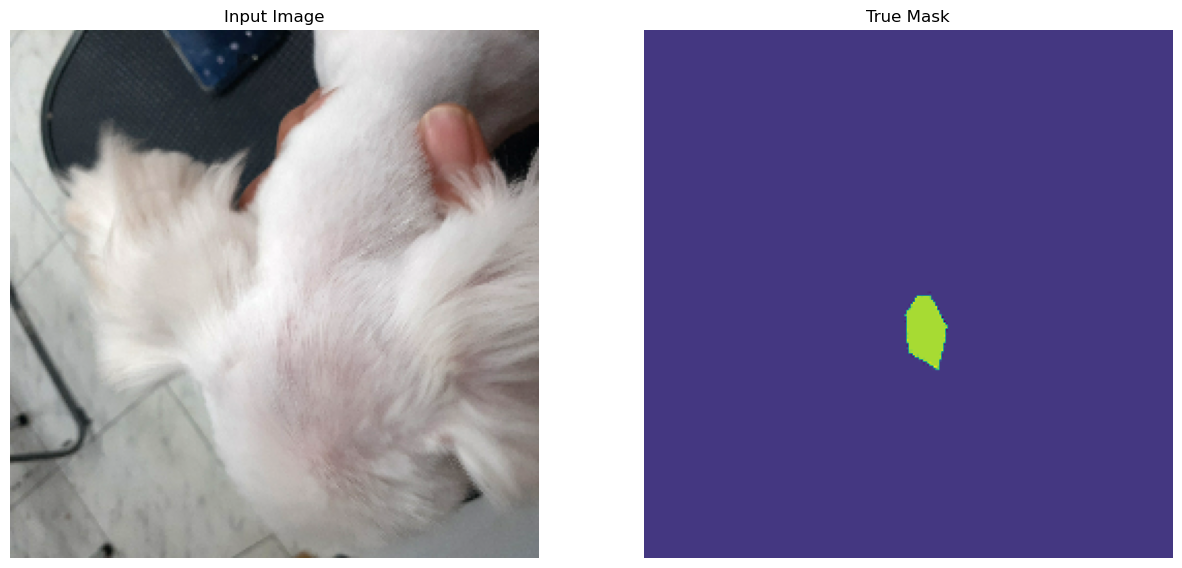

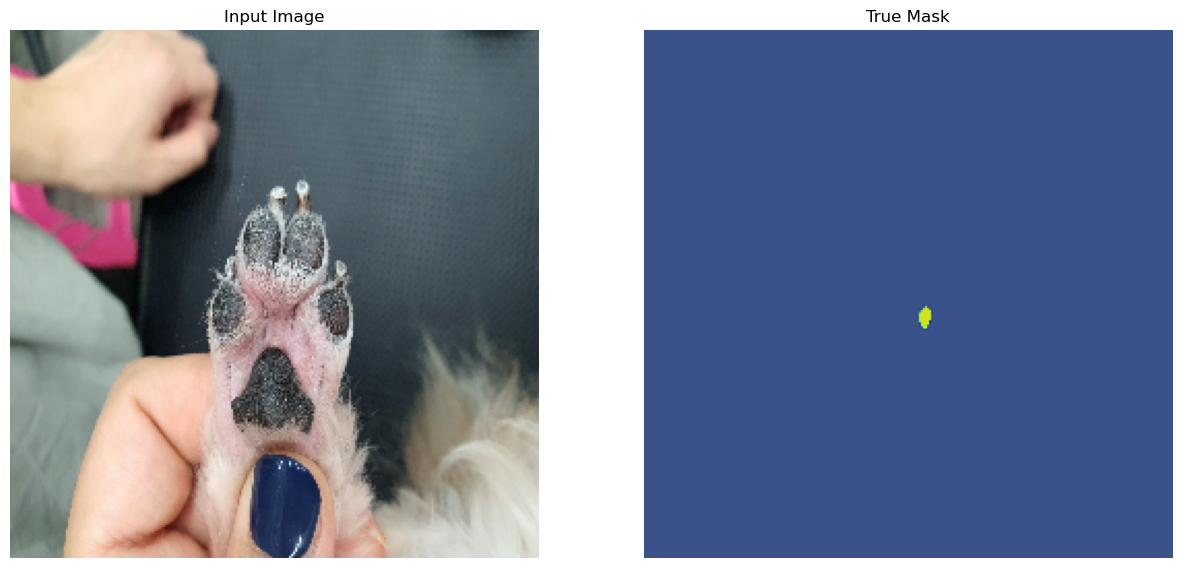

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import keras_tuner as kt

# 데이터 로드 함수 정의
def parse_tfrecord_fn(example):
    feature_description = {
        'Raw_data_ID': tf.io.FixedLenFeature([], tf.string),
        'img_path': tf.io.FixedLenFeature([], tf.string),
        'lesions': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    img_path = tf.strings.join([example['img_path'], tf.constant('/'), example['Raw_data_ID']])
    lesions = tf.strings.split(example['lesions'], ',')  # Split the lesions string

    # channel = 3 (RGB)
    img = tf.io.decode_png(tf.io.read_file(img_path), channels=3)

    # Create mask paths using tf.map_fn
    mask_paths = tf.map_fn(lambda lesion: tf.strings.regex_replace(img_path, 'images', f'train_true_mask_images_{lesion}'), lesions, dtype=tf.string)
    mask_paths = tf.strings.join(['./train_true_mask_images_', lesions, '/mask_', example['Raw_data_ID']])

    # Read and decode masks
    masks = tf.map_fn(lambda mask_path: tf.io.decode_png(tf.io.read_file(mask_path), channels=1), mask_paths, dtype=tf.uint8)

    # Combine masks into a single mask (assuming multiple lesions)
    combined_mask = tf.reduce_max(masks, axis=0)  # Combine masks by taking the maximum value at each pixel

    return img, combined_mask

# TFRecord 파일 리스트
tfrecord_files = './train_symptoms_tfrecords/train_symptoms_A1.tfrecord'
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_tfrecord_fn)

# 데이터셋 준비 함수
def prepare_dataset(dataset, batch_size=2, target_size=(256, 256)):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # 이미지 크기 조정
    def resize_image(image, mask):
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size, method='nearest')  # nearest neighbor interpolation 사용하여 마스크 크기 조정
        mask = tf.cast(mask, tf.float32) / 255.0  # 데이터 형식 변환 및 정규화
        mask = tf.expand_dims(mask, axis=-1)  # 마스크의 채널 축 추가 (image와 일치)
        return image, mask

    dataset = dataset.map(resize_image)
    
    return dataset

# 100개의 샘플링 및 데이터셋 준비
sampled_dataset = dataset.take(100)
train_dataset = prepare_dataset(sampled_dataset)

# 데이터셋 시각화
def display_sample(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i][0]))  # 배치 차원 제거
        else:
            mask = tf.squeeze(display_list[i][0], axis=-1)  # 배치 차원 제거 및 마스크의 채널 축 제거
            plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
        plt.axis('off')
    plt.show()

for image, mask in train_dataset.take(2):
    sample_image, sample_mask = image[0][tf.newaxis, ...], mask[0][tf.newaxis, ...]
    display_sample([sample_image, sample_mask])


In [19]:


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 경고 메시지 숨기기

import tensorflow as tf
from tensorflow.keras import layers, models


# U-Net 모델 정의
def unet_model():
    inputs = layers.Input((256, 256, 3))
    
    # 인코더
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # 디코더
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)

    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)

    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


# # IoU 메트릭 정의
# def iou_metric(y_true, y_pred):
#     y_pred = tf.cast(tf.math.greater(y_pred, 0.5), tf.int32)
#     y_true = tf.cast(y_true, tf.int32)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true + y_pred)
#     iou = intersection / (union - intersection + 1e-7)
#     return iou

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_23 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_22[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_23[0][0]']           
 g2D)                                                                                       

In [20]:
error_count = 0
epochs = 2
history_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    epoch_error_count = 0

    for image, mask in train_dataset:
        try:
            history = model.fit(image, mask, validation_data=(image, mask))
            history_list.append(history)  # Add this line to store history
            model.save('unet_model.h5')
            model.save('saved_model/unet_model')
        except tf.errors.InvalidArgumentError:
            error_count += 1
            epoch_error_count += 1

    print(f"Epoch {epoch+1} - 무시된 오류 횟수: {epoch_error_count}")

print("전체 무시된 오류 횟수:", error_count)


Epoch 1/2
1/1 [==============================] - 4s 4s/step - loss: 4.0818 - accuracy: 0.0000e+00 - val_loss: 38.4041 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 34.7277 - accuracy: 0.0000e+00 - val_loss: 10.9048 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 9.9148 - accuracy: 0.0000e+00 - val_loss: 0.8352 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.8899 - accuracy: 0.0000e+00 - val_loss: 0.9271 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.9053 - accuracy: 0.0000e+00 - val_loss: 3.0209 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 2.7915 - accuracy: 0.0000e+00 - val_loss: 0.7625 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7703 - accuracy: 0.0000e+00 - val_loss: 2.0121 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 1.8919 - accuracy: 0.0000e+00 - val_loss: 1.5431 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 1.5511 - accuracy: 0.0000e+00 - val_loss: 0.7559 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7550 - accuracy: 0.0000e+00 - val_loss: 1.1867 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 1.0401 - accuracy: 0.0000e+00 - val_loss: 1.0801 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 1.2437 - accuracy: 0.0000e+00 - val_loss: 0.8225 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.8397 - accuracy: 0.0000e+00 - val_loss: 0.7355 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7478 - accuracy: 0.0000e+00 - val_loss: 0.9103 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.8541 - accuracy: 0.0000e+00 - val_loss: 0.8667 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.9404 - accuracy: 0.0000e+00 - val_loss: 0.7899 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7754 - accuracy: 0.0000e+00 - val_loss: 0.7047 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6995 - accuracy: 0.0000e+00 - val_loss: 0.7263 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7169 - accuracy: 0.0000e+00 - val_loss: 0.7409 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7575 - accuracy: 0.0000e+00 - val_loss: 0.7606 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7603 - accuracy: 0.0000e+00 - val_loss: 0.7397 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7326 - accuracy: 0.0000e+00 - val_loss: 0.7097 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7102 - accuracy: 0.0000e+00 - val_loss: 0.6972 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6975 - accuracy: 0.0000e+00 - val_loss: 0.6981 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7011 - accuracy: 0.0000e+00 - val_loss: 0.7123 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7092 - accuracy: 0.0000e+00 - val_loss: 0.7169 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7114 - accuracy: 0.0000e+00 - val_loss: 0.7119 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7269 - accuracy: 0.0000e+00 - val_loss: 0.7168 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7150 - accuracy: 0.0000e+00 - val_loss: 0.7049 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7032 - accuracy: 0.0000e+00 - val_loss: 0.6978 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6982 - accuracy: 0.0000e+00 - val_loss: 0.6987 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6979 - accuracy: 0.0000e+00 - val_loss: 0.7031 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7026 - accuracy: 0.0000e+00 - val_loss: 0.7062 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7042 - accuracy: 0.0000e+00 - val_loss: 0.7045 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7072 - accuracy: 0.0000e+00 - val_loss: 0.7039 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.7056 - accuracy: 0.0000e+00 - val_loss: 0.6998 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6988 - accuracy: 0.0000e+00 - val_loss: 0.6964 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6974 - accuracy: 0.0000e+00 - val_loss: 0.6971 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6974 - accuracy: 0.0000e+00 - val_loss: 0.6991 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6983 - accuracy: 0.0000e+00 - val_loss: 0.6996 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6984 - accuracy: 0.0000e+00 - val_loss: 0.6989 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6998 - accuracy: 0.0000e+00 - val_loss: 0.6991 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6979 - accuracy: 0.0000e+00 - val_loss: 0.6965 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6973 - accuracy: 0.0000e+00 - val_loss: 0.6957 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6987 - accuracy: 0.0000e+00 - val_loss: 0.6968 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6953 - accuracy: 0.0000e+00 - val_loss: 0.6960 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6980 - accuracy: 0.0000e+00 - val_loss: 0.6985 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6965 - accuracy: 0.0000e+00 - val_loss: 0.6967 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6969 - accuracy: 0.0000e+00 - val_loss: 0.6964 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6960 - accuracy: 0.0000e+00 - val_loss: 0.6953 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


Epoch 1 - 무시된 오류 횟수: 0
Epoch 2/2
1/1 [==============================] - 2s 2s/step - loss: 0.6951 - accuracy: 0.0000e+00 - val_loss: 0.6944 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6952 - accuracy: 0.0000e+00 - val_loss: 0.6950 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6964 - accuracy: 0.0000e+00 - val_loss: 0.6965 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6947 - accuracy: 0.0000e+00 - val_loss: 0.6948 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6962 - accuracy: 0.0000e+00 - val_loss: 0.6963 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6957 - accuracy: 0.0000e+00 - val_loss: 0.6956 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6954 - accuracy: 0.0000e+00 - val_loss: 0.6952 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6949 - accuracy: 0.0000e+00 - val_loss: 0.6947 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6946 - accuracy: 0.0000e+00 - val_loss: 0.6945 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6946 - accuracy: 0.0000e+00 - val_loss: 0.6946 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6941 - accuracy: 0.0000e+00 - val_loss: 0.6941 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6956 - accuracy: 0.0000e+00 - val_loss: 0.6955 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6946 - accuracy: 0.0000e+00 - val_loss: 0.6945 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6950 - accuracy: 0.0000e+00 - val_loss: 0.6949 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6943 - accuracy: 0.0000e+00 - val_loss: 0.6942 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6943 - accuracy: 0.0000e+00 - val_loss: 0.6942 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6940 - accuracy: 0.0000e+00 - val_loss: 0.6940 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6940 - accuracy: 0.0000e+00 - val_loss: 0.6940 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6965 - accuracy: 0.0000e+00 - val_loss: 0.6964 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6942 - accuracy: 0.0000e+00 - val_loss: 0.6942 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6946 - accuracy: 0.0000e+00 - val_loss: 0.6945 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6943 - accuracy: 0.0000e+00 - val_loss: 0.6942 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6948 - accuracy: 0.0000e+00 - val_loss: 0.6948 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6943 - accuracy: 0.0000e+00 - val_loss: 0.6943 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6938 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6944 - accuracy: 0.0000e+00 - val_loss: 0.6944 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6954 - accuracy: 0.0000e+00 - val_loss: 0.6954 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6940 - accuracy: 0.0000e+00 - val_loss: 0.6939 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6944 - accuracy: 0.0000e+00 - val_loss: 0.6943 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6941 - accuracy: 0.0000e+00 - val_loss: 0.6941 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6937 - accuracy: 0.0000e+00 - val_loss: 0.6935 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6936 - accuracy: 0.0000e+00 - val_loss: 0.6943 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6950 - accuracy: 0.0000e+00 - val_loss: 0.6936 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6940 - accuracy: 0.0000e+00 - val_loss: 0.6941 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6938 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6945 - accuracy: 0.0000e+00 - val_loss: 0.6944 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6942 - accuracy: 0.0000e+00 - val_loss: 0.6939 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6936 - accuracy: 0.0000e+00 - val_loss: 0.6937 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6948 - accuracy: 0.0000e+00 - val_loss: 0.6949 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6939 - accuracy: 0.0000e+00 - val_loss: 0.6939 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6946 - accuracy: 0.0000e+00 - val_loss: 0.6945 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6941 - accuracy: 0.0000e+00 - val_loss: 0.6941 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6934 - accuracy: 0.0000e+00 - val_loss: 0.6935 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6935 - accuracy: 0.0000e+00 - val_loss: 0.6935 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6938 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6937 - accuracy: 0.0000e+00 - val_loss: 0.6937 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6938 - accuracy: 0.0000e+00 - val_loss: 0.6937 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6937 - accuracy: 0.0000e+00 - val_loss: 0.6937 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6942 - accuracy: 0.0000e+00 - val_loss: 0.6942 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


1/1 [==============================] - 2s 2s/step - loss: 0.6938 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.0000e+00


C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


Epoch 2 - 무시된 오류 횟수: 0
전체 무시된 오류 횟수: 0


In [ ]:
import matplotlib.pyplot as plt


def plot_history(history_list):
    train_loss = []
    val_loss = []

    for history in history_list:
        train_loss.extend(history.history['loss'])
        val_loss.extend(history.history['val_loss'])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_list)
